In [1]:
import pandas as pd
import numpy as np

import os
import io
import base64
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai.vision.all import *
import torch.nn.functional as nnf

In [2]:
from scclib.util.image import create_samples, assemble_rgb_image, get_rgb_pieces_tensors, HPAImage

C:\Users\Marianne\source\repos\SingleCellClassification\scclib\util\image.py:157: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if mode is not "RGB":


In [3]:
cuda0 = torch.device('cuda:0')

In [4]:
data_path = Path('Z:\cloud\data\hpa-single-cell-image-classification')
path = Path('../data')

In [5]:
df = pd.read_csv(data_path/'train.csv')

In [6]:
df.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [7]:
labels = [str(i) for i in range(19)]
for x in labels:
    df[x] = df['Label'].apply(lambda r: int(x in r.split('|')))

In [8]:
dfs_0 = df[df['Label'] == '0'].sample(n=300, random_state=42).reset_index(drop=True)
dfs_1 = df[df['1'] == 1].sample(n=400, random_state=42).reset_index(drop=True)
dfs_1u = df[df['Label'] == '1'].sample(n=221, random_state=42).reset_index(drop=True)
dfs_2 = df[df['Label'] == '2'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_3 = df[df['Label'] == '3'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_4 = df[df['Label'] == '4'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_5 = df[df['Label'] == '5'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_6 = df[df['6'] == 1].sample(n=500, random_state=42).reset_index(drop=True)
dfs_7 = df[df['Label'] == '7'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_8 = df[df['Label'] == '8'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_9 = df[df['9'] == 1].sample(n=400, random_state=42).reset_index(drop=True)
dfs_9u = df[df['Label'] == '9'].sample(n=200, random_state=42).reset_index(drop=True)
dfs_10 = df[df['10'] == 1].sample(n=400, random_state=42).reset_index(drop=True)
dfs_10u = df[df['Label'] == '10'].sample(n=200, random_state=42).reset_index(drop=True)
dfs_11 = df[df['11'] == 1].reset_index(drop=True)
dfs_12 = df[df['Label'] == '12'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_13 = df[df['Label'] == '13'].sample(n=400, random_state=42).reset_index(drop=True)
dfs_14 = df[df['Label'] == '14'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_15 = df[df['15'] == 1].reset_index(drop=True)
dfs_16 = df[df['Label'] == '16'].sample(n=350, random_state=42).reset_index(drop=True)
dfs_17 = df[df['17'] == 1].sample(n=500, random_state=42).reset_index(drop=True)
dfs_18 = df[df['18'] == 1].reset_index(drop=True)
dfs_ = [dfs_0, dfs_1, dfs_1u, dfs_2, dfs_3, dfs_4, dfs_5, dfs_6, dfs_7, dfs_8, dfs_9, dfs_9u, dfs_10, dfs_10u,
        dfs_11, dfs_12, dfs_13, dfs_14, dfs_15, dfs_16, dfs_17, dfs_18]

In [9]:
dfs = pd.concat(dfs_, ignore_index=True)
dfs.drop_duplicates(inplace=True, ignore_index=True)

In [10]:
data_path = Path('../data')

image_path = Path('Z:/cloud/data/hpa-single-cell-image-classification/train')
image_destination = data_path/'train'

if not image_destination.exists():
    os.makedirs(image_destination)

In [11]:
example_image = image_path.ls()[0].name
image_id, image_ext = example_image.split('.')

image_id = image_id.split('_')[0]

C:\Users\Marianne\source\repos\SingleCellClassification\scclib\util\image.py:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(arr)


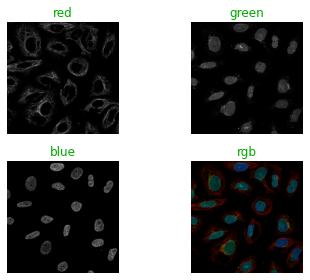

In [12]:
new_img = HPAImage(id=image_id,
                   ext=image_ext,
                   path=image_path,
                   device="cuda:0",
                   size=460)

new_img.plot_all()

In [ ]:


r, g, b = get_rgb_pieces_tensors(image_path/image_id, image_ext, 460, "cuda:0")
image = assemble_rgb_image(r, g, b, device="cuda:0")


show_images([image])

In [ ]:
create_samples(460, dfs, image_path, image_destination, csv_path=data_path/'cells_sample.csv', device="cuda:0")
